# Download the datasets

https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

In [160]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder


In [161]:
skin_df = pd.read_csv('data/HAM10000_metadata.csv')
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [162]:
SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [163]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

In [164]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,0


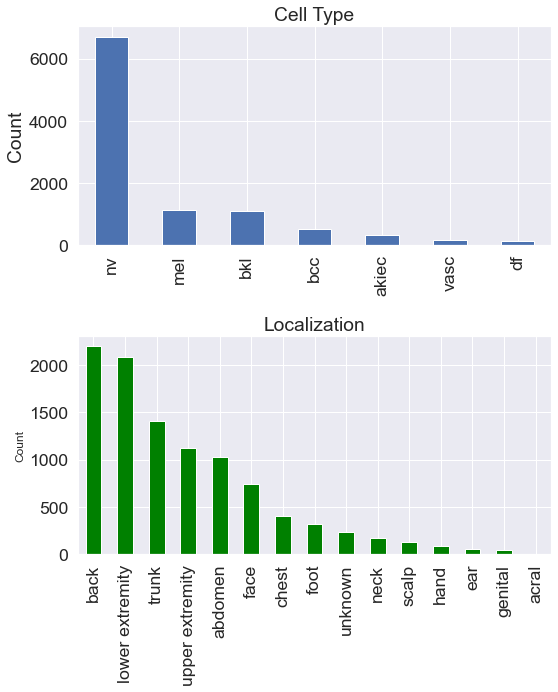

In [165]:
# Data distribution visualization

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');


ax2 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar',color='green')
ax2.set_ylabel('Count',size=12)
ax2.set_title('Localization')


plt.tight_layout()
plt.show()


In [166]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [167]:
#Balance data.

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [168]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [169]:
#Define the path and add as a new column
skin_df_balanced['path']='data/HAM10000/'+skin_df_balanced['image_id']+'.jpg'

In [170]:
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x:np.asarray(Image.open(x).resize((SIZE,SIZE))))

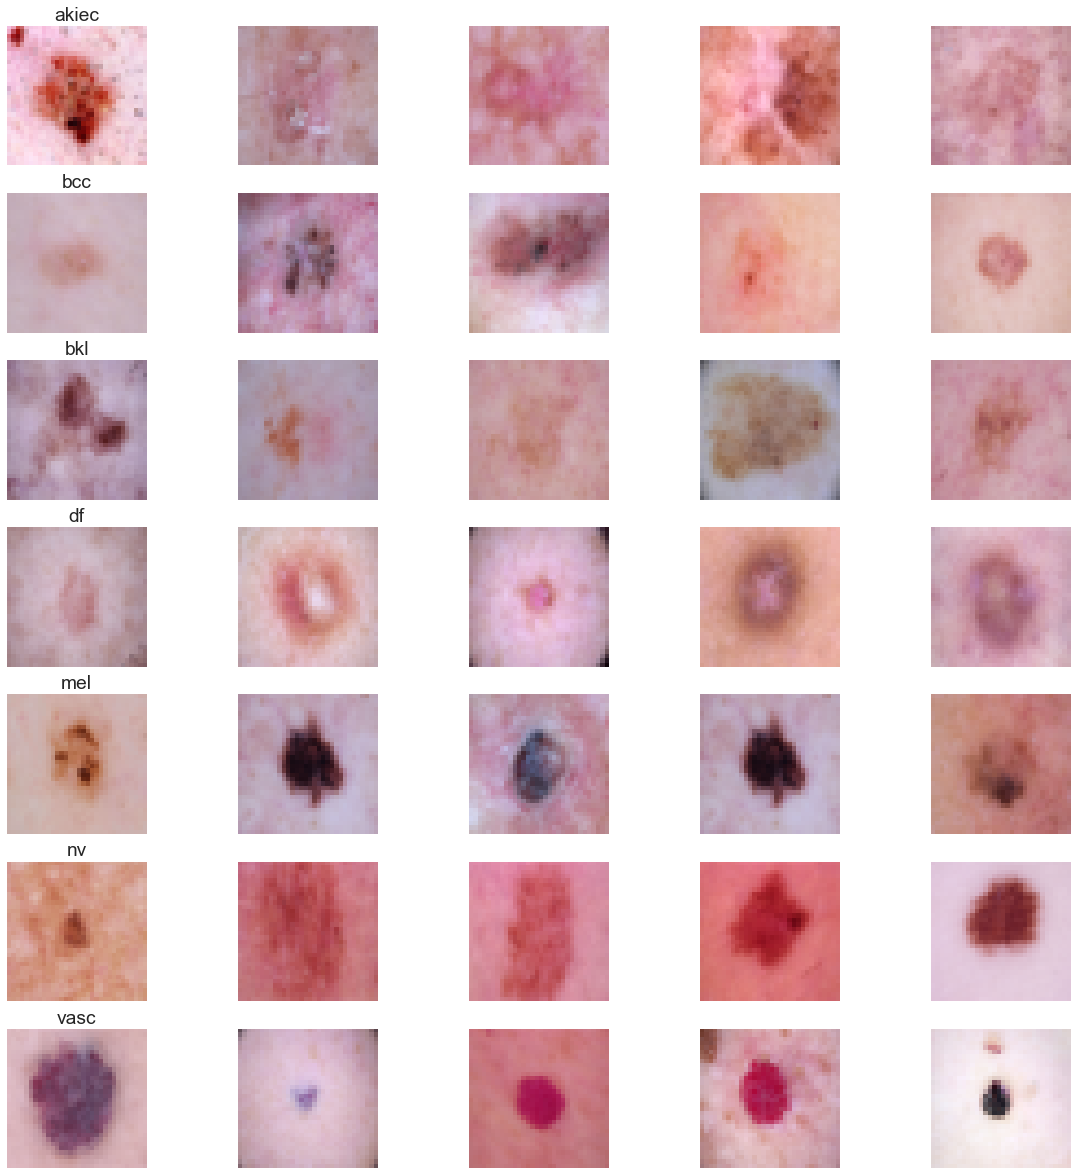

In [171]:
n_samples = 5

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [172]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.

In [173]:
Y=skin_df_balanced['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem

In [174]:
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [175]:
#Define the model.
#I've used autokeras to find out the best model for this problem.

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))

#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3),activation='relu'))

#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3),activation='relu'))

#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 15, 15, 256)      0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 15, 15, 256)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 6, 6, 128)        

In [177]:
from tensorflow.keras.callbacks import EarlyStopping


In [178]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)


In [179]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 60

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)

Epoch 1/60
165/165 - 10s - loss: 0.7492 - acc: 0.7227 - val_loss: 0.8522 - val_acc: 0.7086 - 10s/epoch - 60ms/step
Epoch 2/60
165/165 - 10s - loss: 0.6542 - acc: 0.7490 - val_loss: 0.8151 - val_acc: 0.7269 - 10s/epoch - 60ms/step
Epoch 3/60
165/165 - 10s - loss: 0.6424 - acc: 0.7543 - val_loss: 0.7748 - val_acc: 0.7451 - 10s/epoch - 60ms/step
Epoch 4/60
165/165 - 10s - loss: 0.6471 - acc: 0.7585 - val_loss: 0.8015 - val_acc: 0.7326 - 10s/epoch - 61ms/step
Epoch 5/60
165/165 - 10s - loss: 0.6057 - acc: 0.7608 - val_loss: 0.8158 - val_acc: 0.7234 - 10s/epoch - 60ms/step
Epoch 6/60
165/165 - 10s - loss: 0.6392 - acc: 0.7646 - val_loss: 1.0084 - val_acc: 0.6640 - 10s/epoch - 61ms/step
Epoch 7/60
165/165 - 10s - loss: 0.6024 - acc: 0.7699 - val_loss: 0.7801 - val_acc: 0.7291 - 10s/epoch - 60ms/step
Epoch 8/60
165/165 - 10s - loss: 0.6145 - acc: 0.7794 - val_loss: 0.7925 - val_acc: 0.7349 - 10s/epoch - 60ms/step
Epoch 9/60
165/165 - 10s - loss: 0.6106 - acc: 0.7684 - val_loss: 0.8098 - val_a

In [159]:
print('Test accuracy:', score[1]*100,"%")

Test accuracy: 74.97143149375916 %


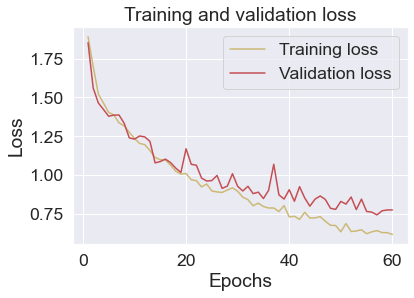

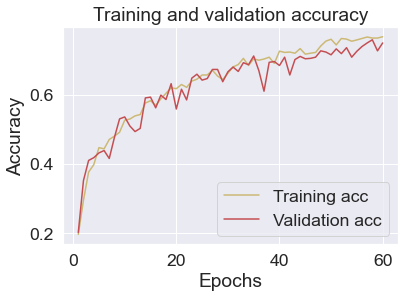

In [146]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [147]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1)

28/28 [==============================] - 2s 54ms/step


<AxesSubplot:>

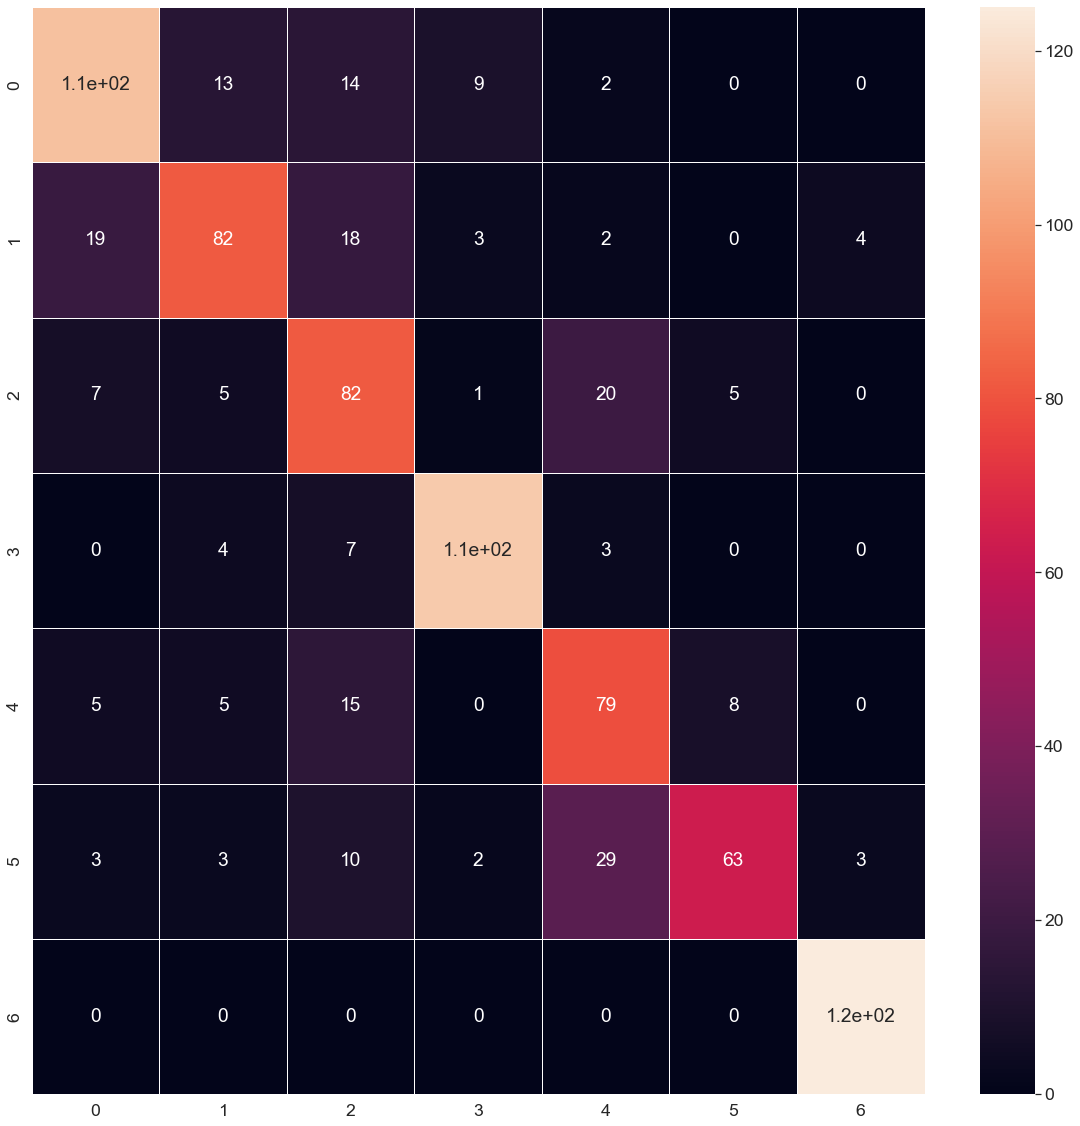

In [148]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)